In [1]:
# import os
import numpy as np
import math
import torch
import torch.nn as nn
# import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        # return torch.FloatTensor([point, self.func(point)])
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10

In [5]:
MIN = -30
MAX = 30
NUM = 15000

In [6]:
data = Data(FUNC, MIN, MAX, NUM)
data[0]

tensor([ 2.5560, -0.0393])

In [7]:
data_loader = DataLoader(data, batch_size = 500, shuffle=True)

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

In [9]:
class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(2, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
    self.linear_3 = nn.Linear(hidden_dim // 2, 1)

  def forward(self, x): 
    
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.sigmoid(x)
    return x

In [10]:
n_epochs = 2000  # количество эпох
lr = 0.01  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 1  # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64

In [11]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [12]:
d_loss_history = []
g_loss_history = []

### Learning process

Epoch: 10; Discriminator_loss: 0.681; Generator_loss: 0.743


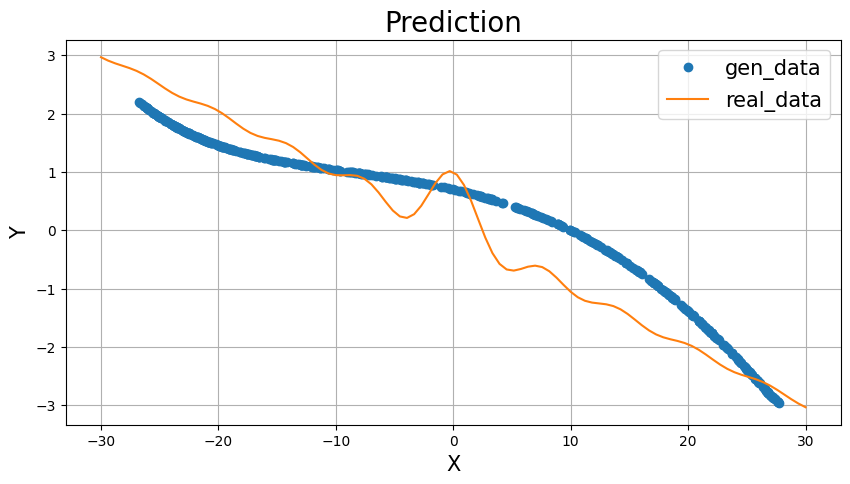

Epoch: 20; Discriminator_loss: 0.632; Generator_loss: 0.938


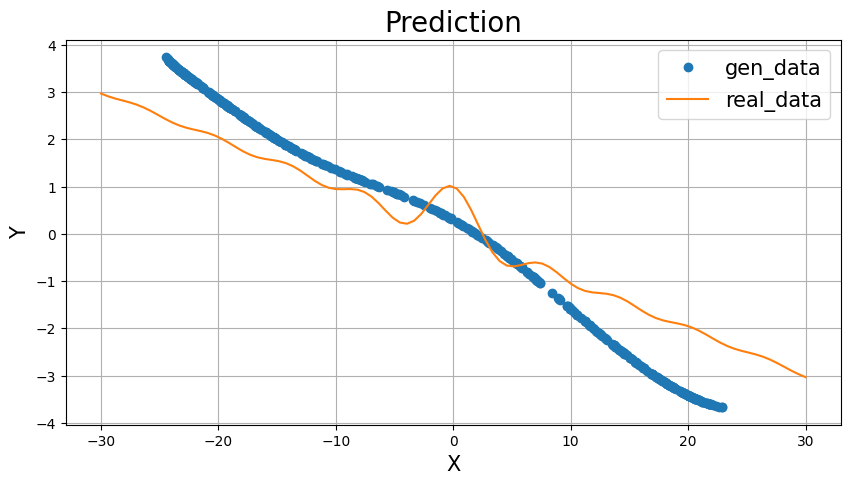

Epoch: 30; Discriminator_loss: 0.626; Generator_loss: 0.934


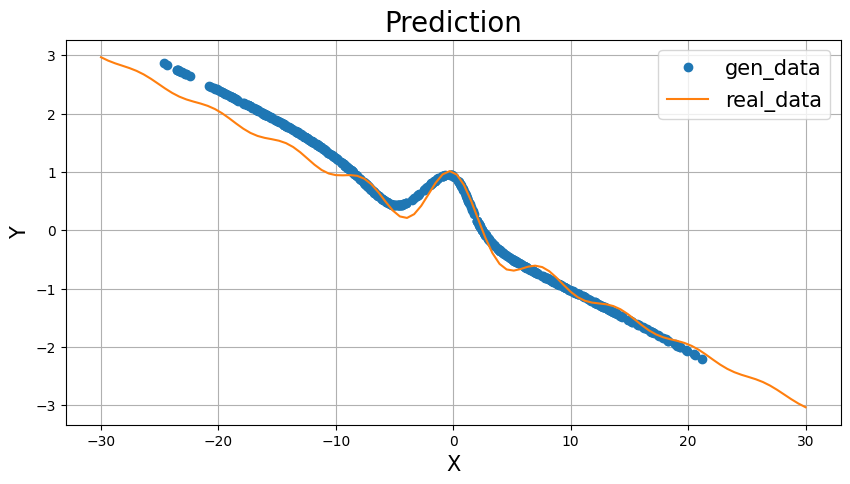

Epoch: 40; Discriminator_loss: 0.663; Generator_loss: 0.777


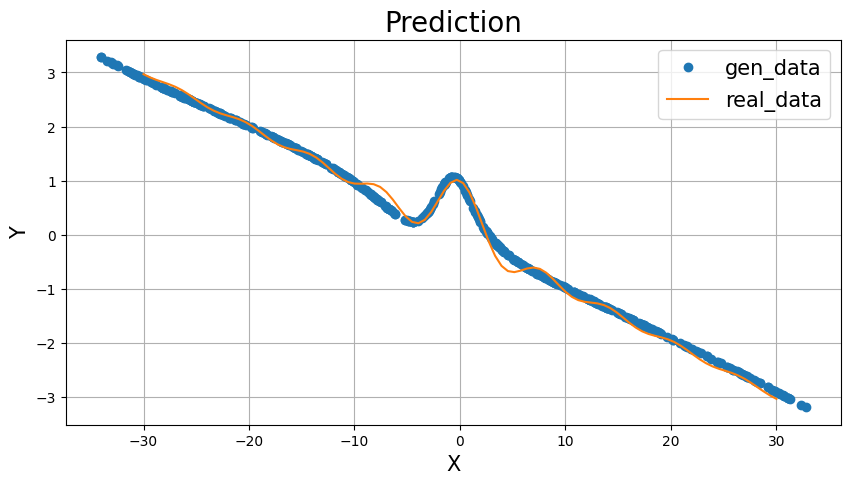

Epoch: 50; Discriminator_loss: 0.66; Generator_loss: 0.773


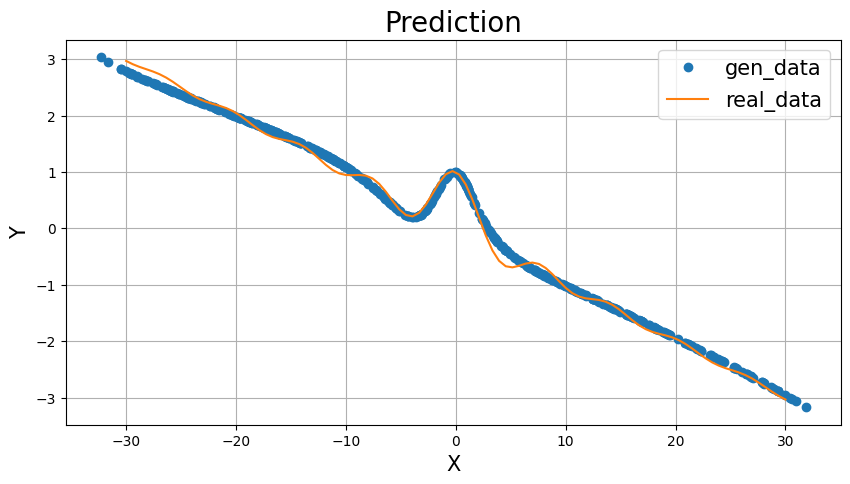

Epoch: 60; Discriminator_loss: 0.652; Generator_loss: 0.815


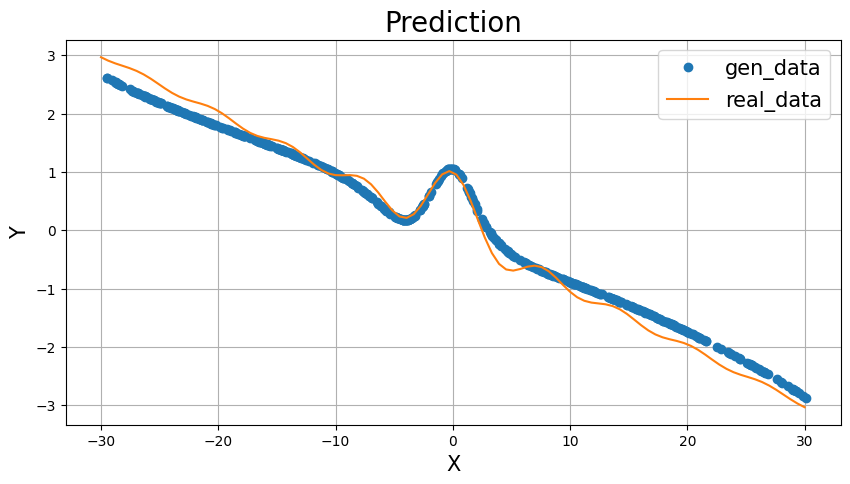

Epoch: 70; Discriminator_loss: 0.658; Generator_loss: 0.802


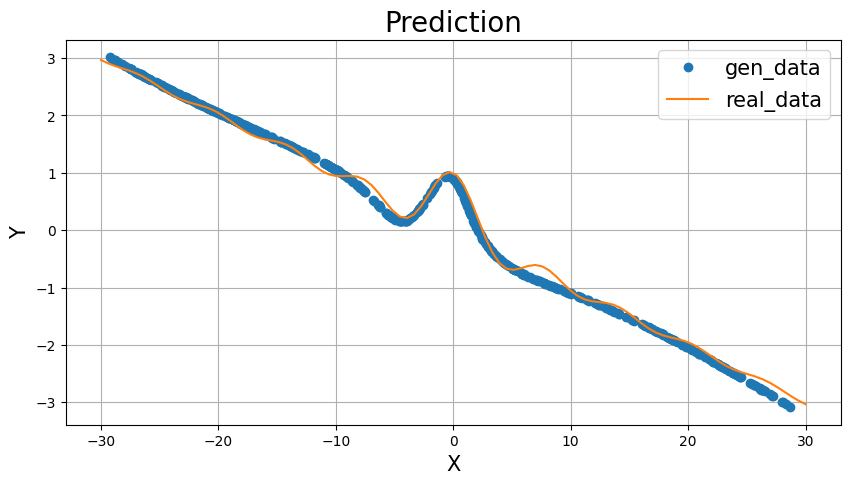

Epoch: 80; Discriminator_loss: 0.665; Generator_loss: 0.833


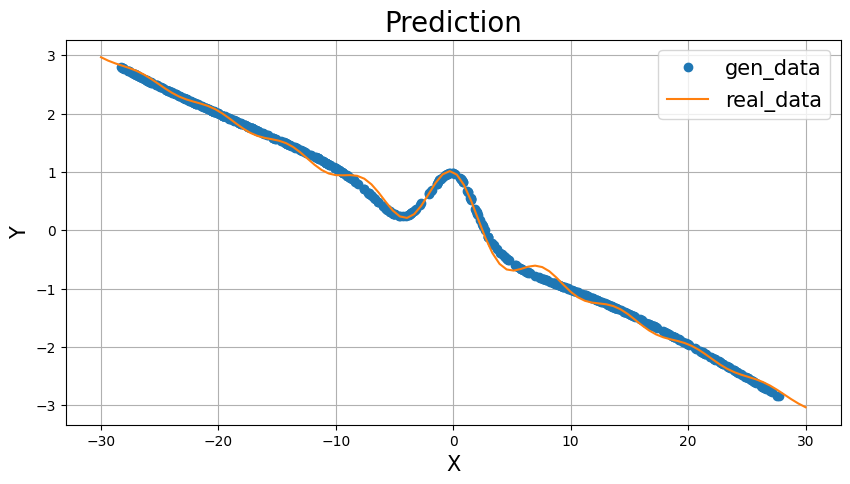

Epoch: 90; Discriminator_loss: 0.655; Generator_loss: 0.846


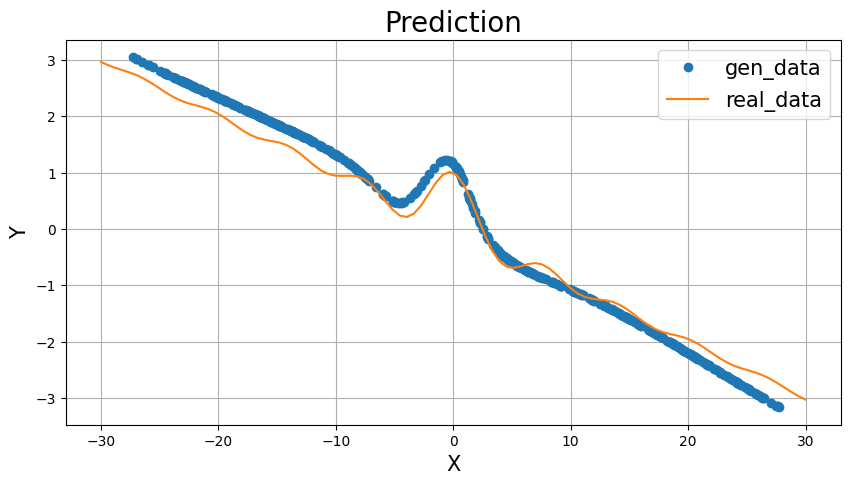

Epoch: 100; Discriminator_loss: 0.659; Generator_loss: 0.84


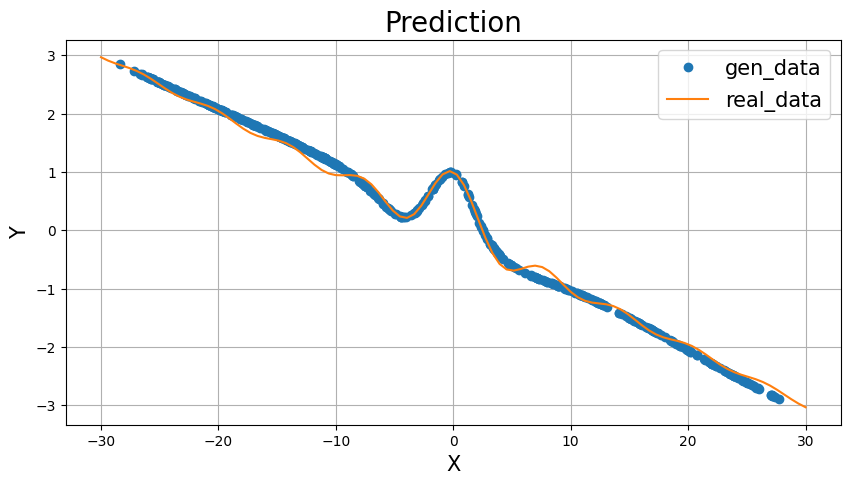

Epoch: 200; Discriminator_loss: 0.673; Generator_loss: 0.786


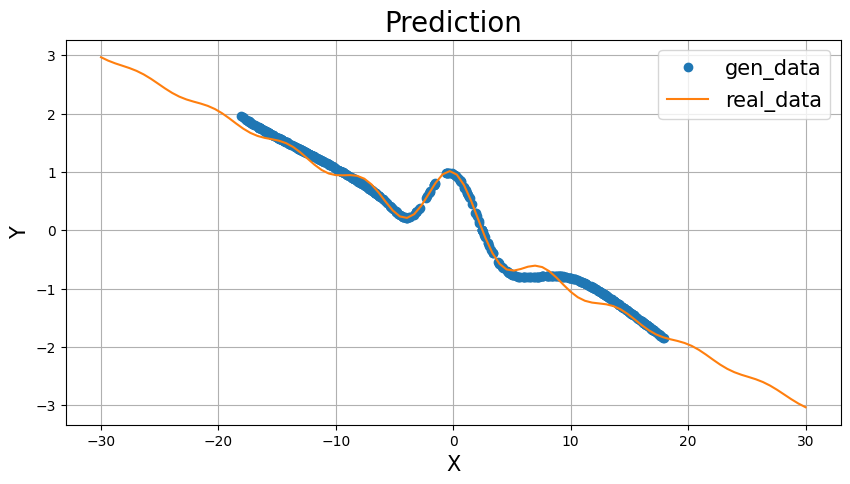

Epoch: 300; Discriminator_loss: 0.671; Generator_loss: 0.869


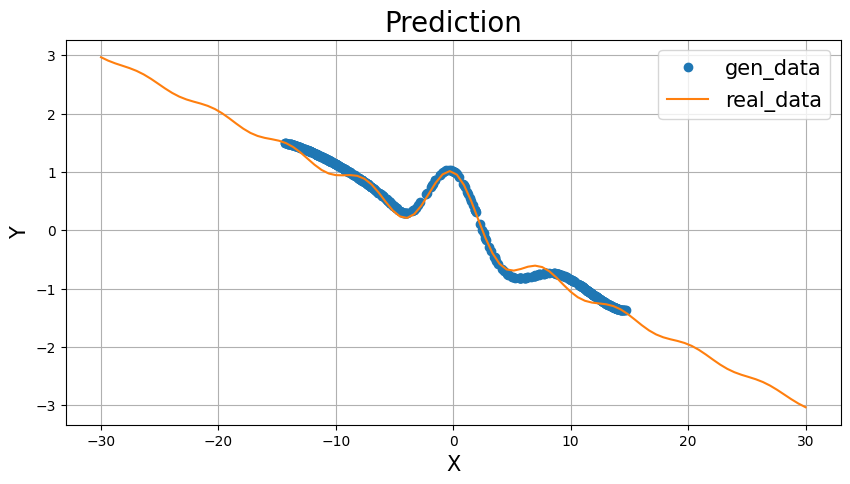

Epoch: 400; Discriminator_loss: 0.672; Generator_loss: 0.885


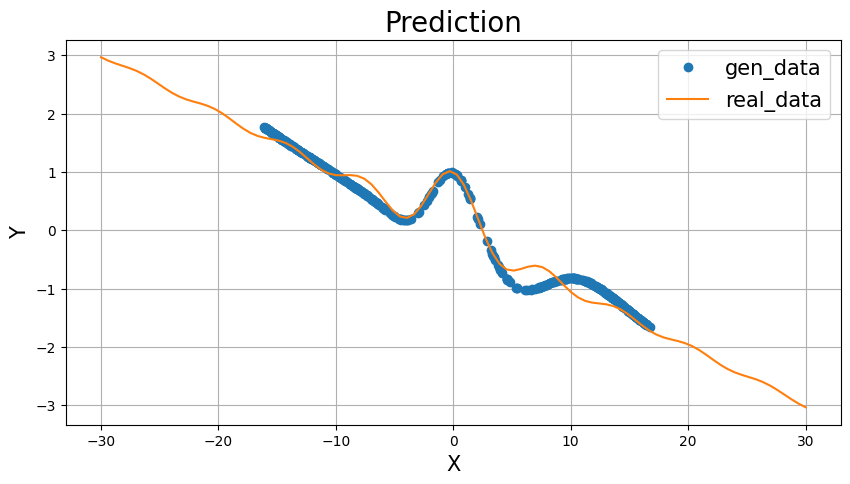

Epoch: 500; Discriminator_loss: 0.682; Generator_loss: 0.734


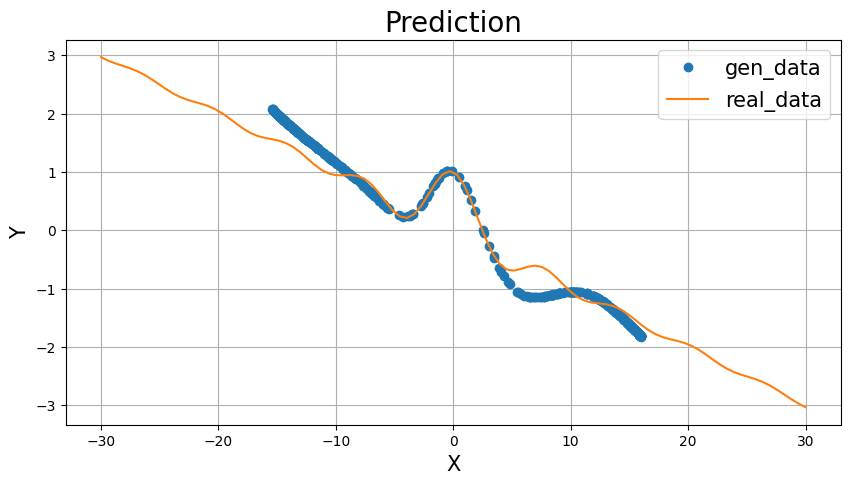

Epoch: 600; Discriminator_loss: 0.621; Generator_loss: 1.095


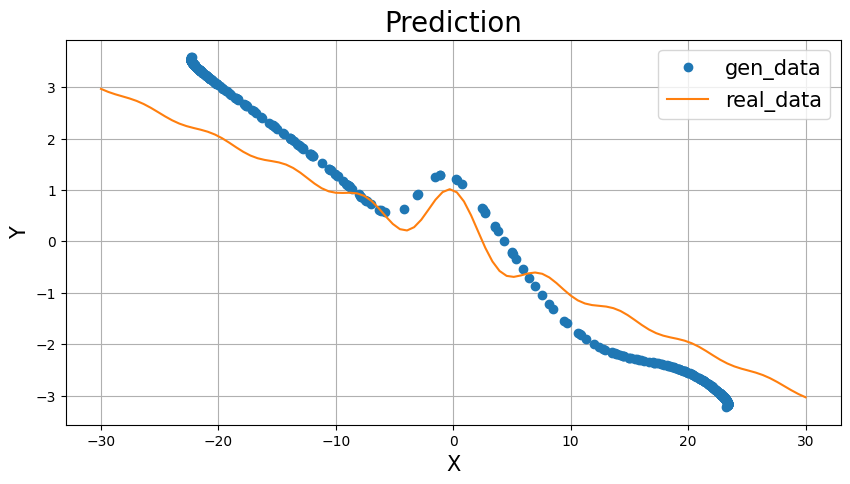

Epoch: 700; Discriminator_loss: 0.599; Generator_loss: 0.849


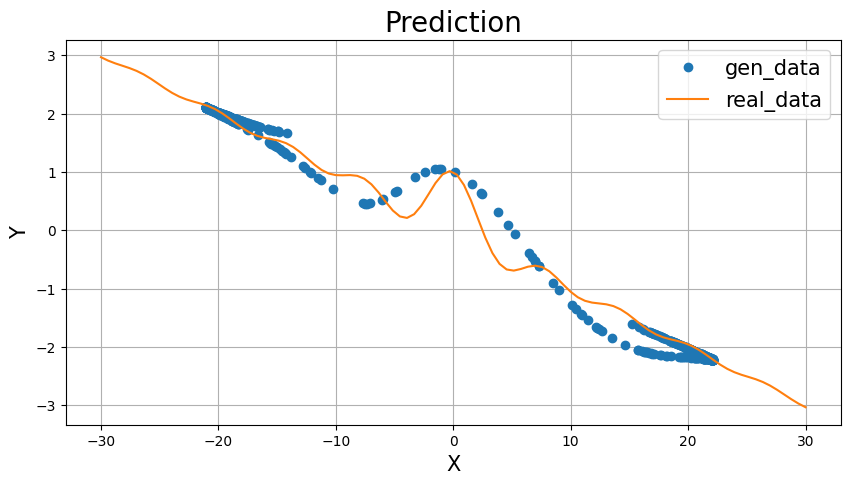

Epoch: 800; Discriminator_loss: 0.641; Generator_loss: 0.823


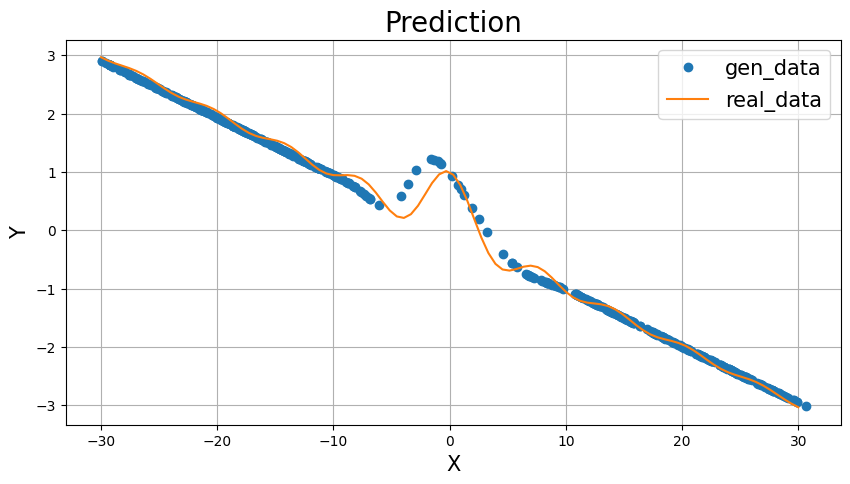

Epoch: 900; Discriminator_loss: 0.623; Generator_loss: 0.855


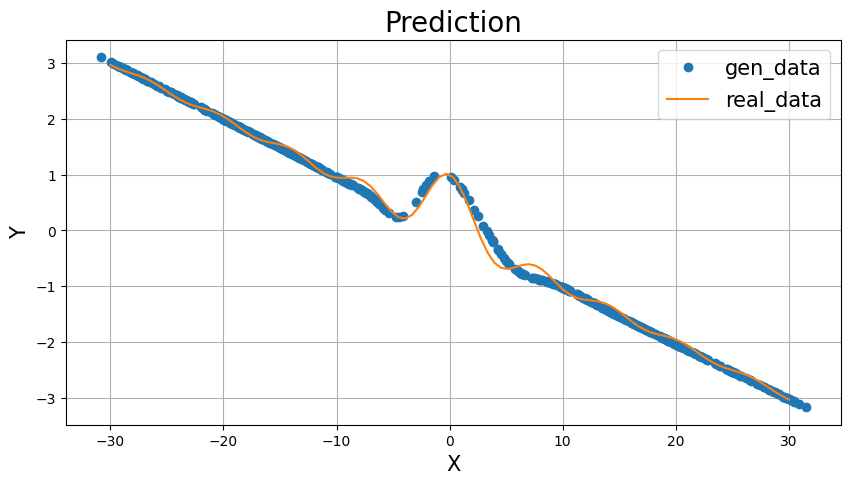

Epoch: 1000; Discriminator_loss: 0.628; Generator_loss: 0.829


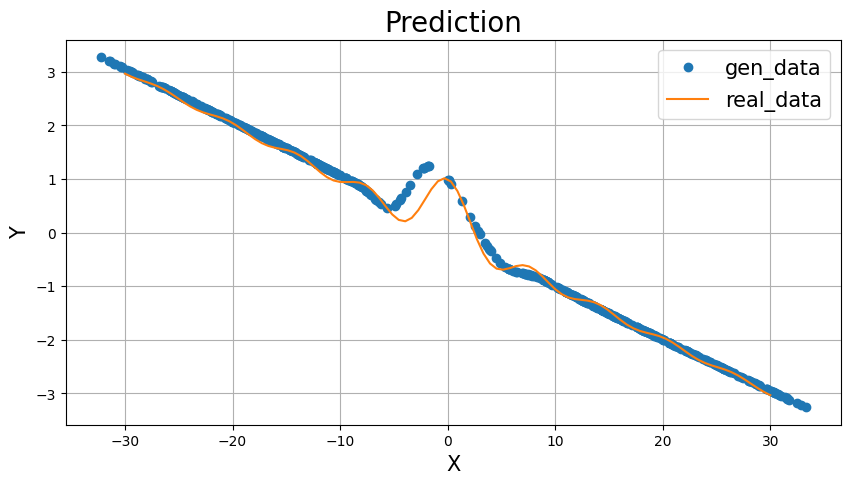

Epoch: 1100; Discriminator_loss: 0.621; Generator_loss: 0.857


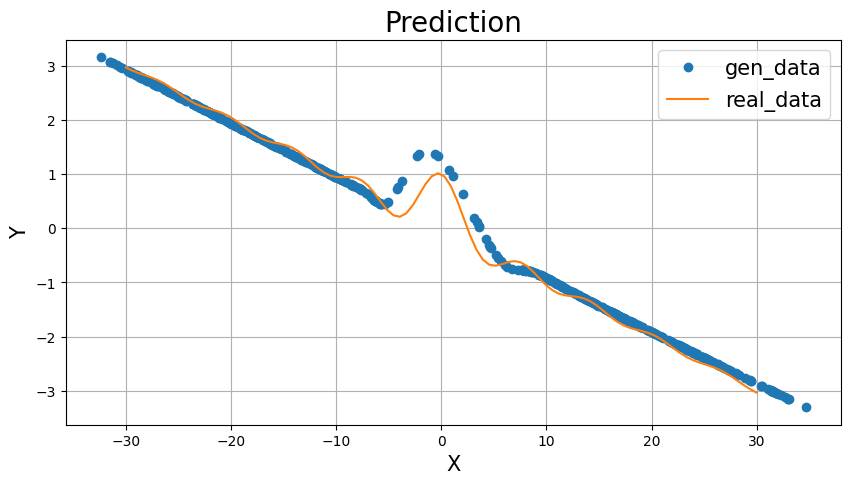

Epoch: 1200; Discriminator_loss: 0.621; Generator_loss: 0.914


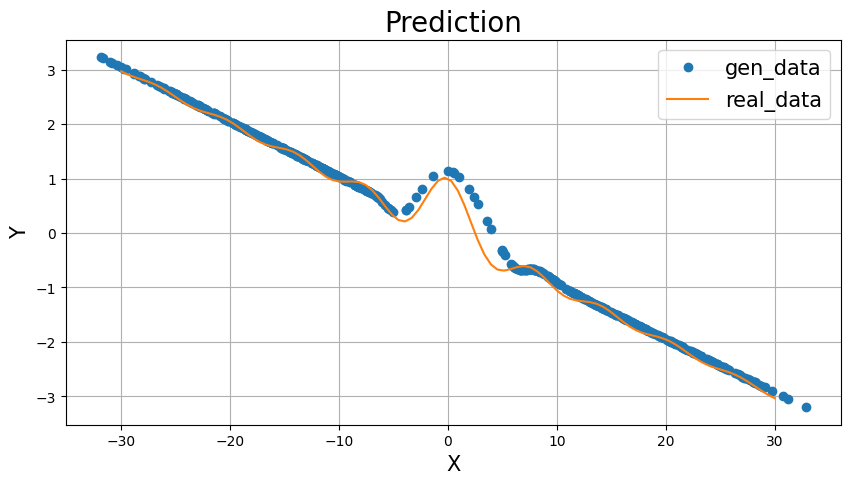

Epoch: 1300; Discriminator_loss: 0.615; Generator_loss: 0.889


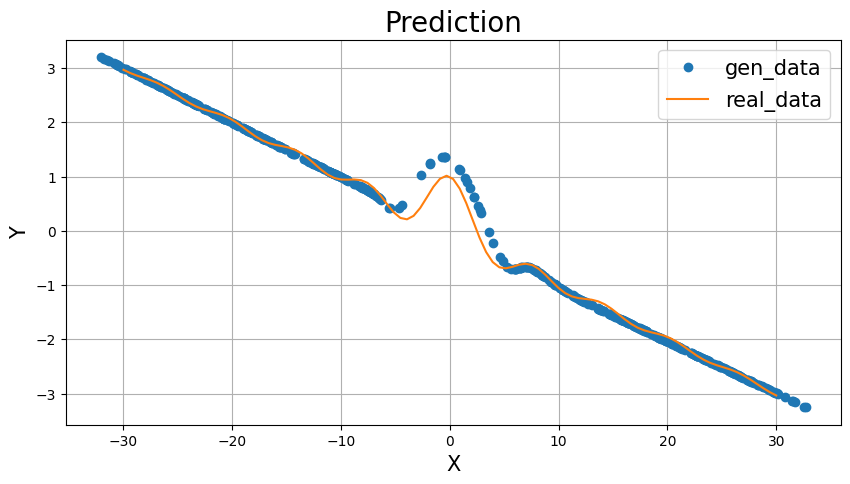

Epoch: 1400; Discriminator_loss: 0.633; Generator_loss: 0.835


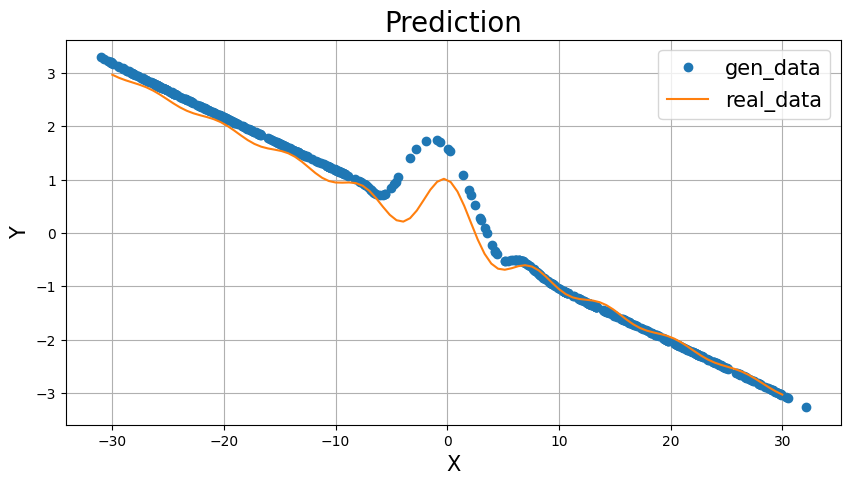

Epoch: 1500; Discriminator_loss: 0.635; Generator_loss: 0.856


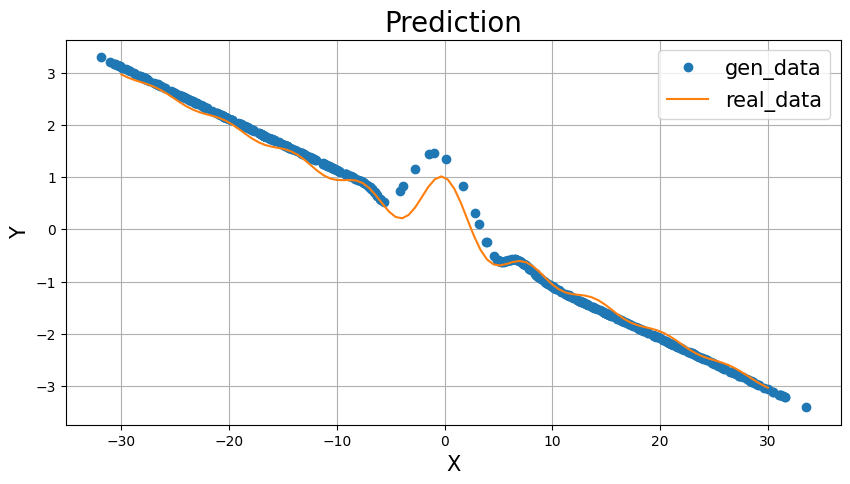

Epoch: 1600; Discriminator_loss: 0.623; Generator_loss: 0.873


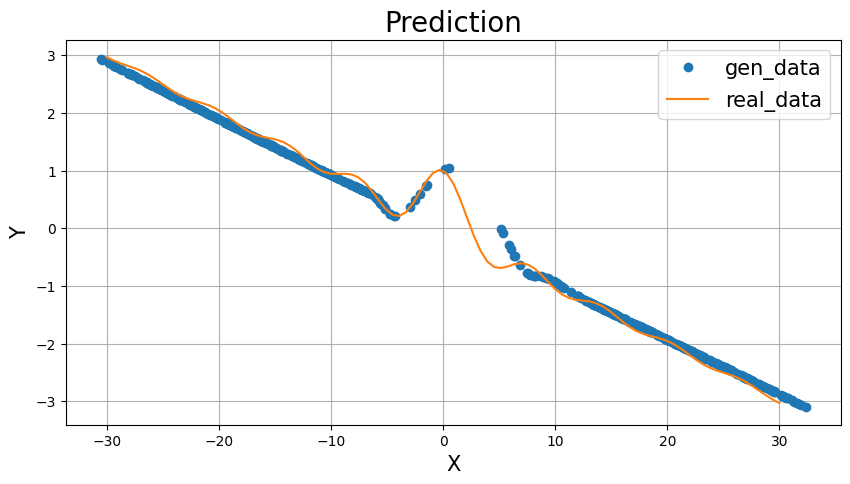

Epoch: 1700; Discriminator_loss: 0.61; Generator_loss: 0.883


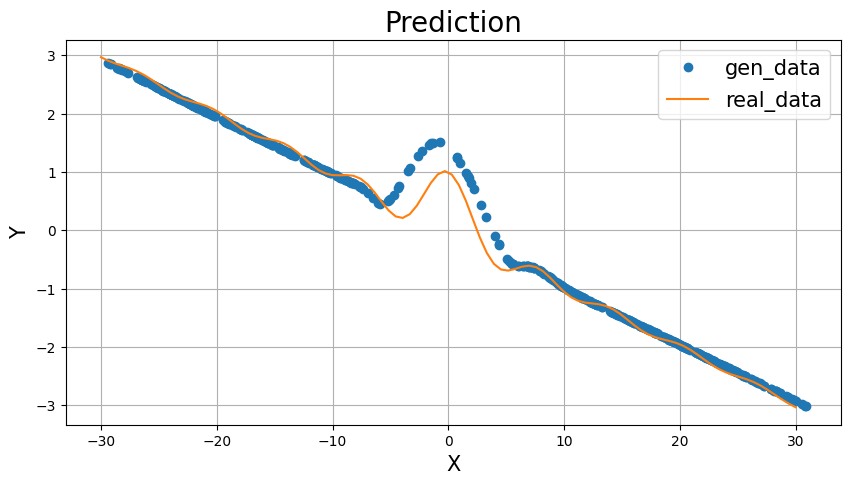

Epoch: 1800; Discriminator_loss: 0.001; Generator_loss: 6.361


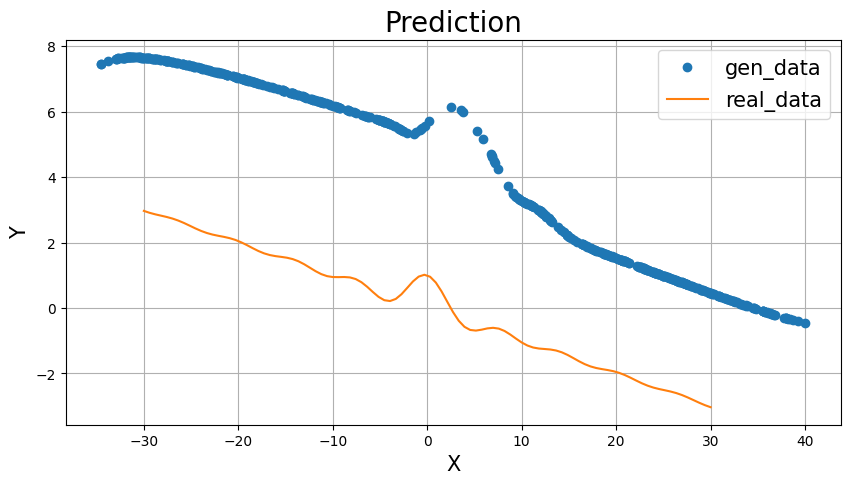

Epoch: 1900; Discriminator_loss: 0.0; Generator_loss: 8.203


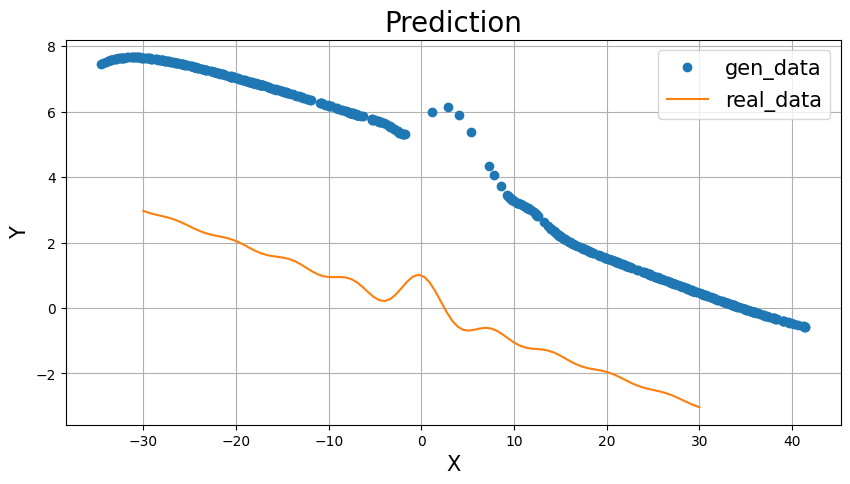

Epoch: 2000; Discriminator_loss: 0.284; Generator_loss: 3.749


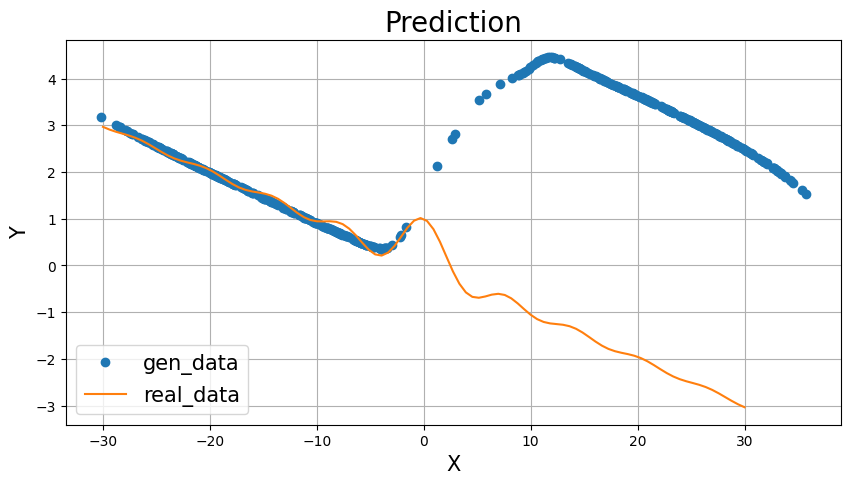

In [13]:
for epoch in range(n_epochs):    

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума        
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
        
######## Отображение процесса обучения и вывод функций потерь ############
    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
    
        plt.figure(figsize = (10,5))
        plt.title('Prediction', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()
    
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

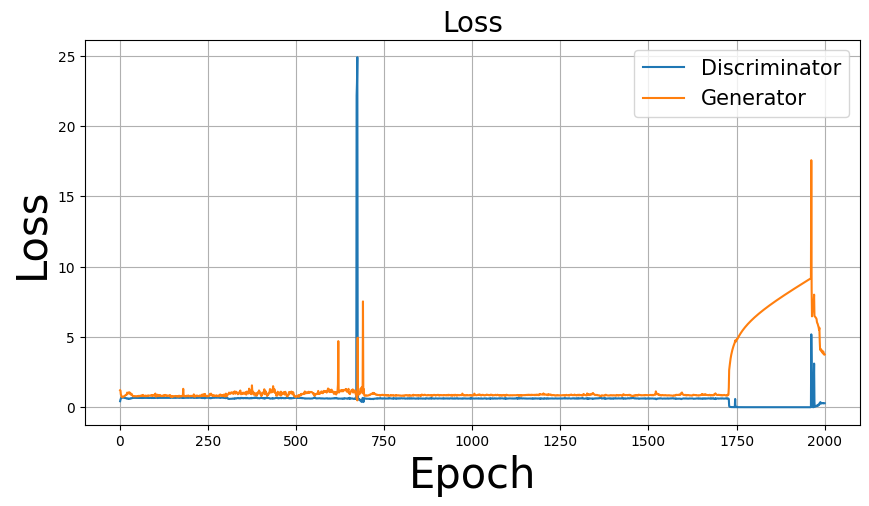

In [15]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 30)
plt.xlabel('Epoch', fontsize = 30)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);